In [1]:
img_rows=28
img_cols=28
channels=1
img_shape=(img_rows, img_cols, channels)
print(img_shape)

(28, 28, 1)


In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

def build_generator():
  noise_shape = (100,)

  model = Sequential()

  model.add(Dense(256, input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))

  return model

In [3]:
def build_discriminator():
  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [4]:
half_batch = 16
idx = np.random.randint(0,60000, half_batch)
print(idx)

[10484 58882 30162  6625  4845  2141  9798 32057   140 54688 17658 39749
 36815 42686 41373  6981]


In [5]:
noise = np.random.normal(0, 1, (half_batch, 100))
print(noise.shape)

(16, 100)


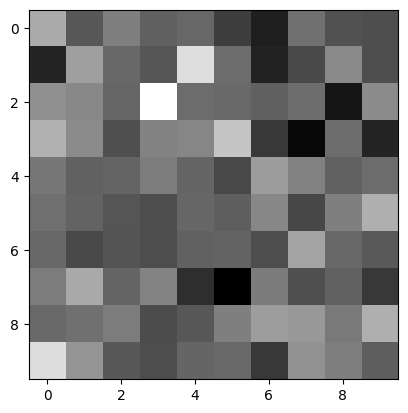

In [6]:
from matplotlib import pyplot as plt
plt.imshow(noise[15].reshape(10,10), cmap='gray')

In [7]:
batch_size=32
half_batch = int(batch_size/2)
print(half_batch)

16


In [8]:
(train_data,_),(_,_) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
np.random.randint(0, train_data.shape[0], half_batch)

array([56862, 29808, 43908, 36615, 27614, 43228,  7965, 12011, 11749,
       28818,   456, 28302, 13155,  1133, 59811,  4769])

In [10]:
noise=np.random.normal(0,1,(half_batch,100))

In [11]:
np.ones((half_batch,1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [15]:
def train(epochs, batch_size, save_interval):
  (train_data,_),(_,_) = mnist.load_data()
  train_data = (train_data.astype(np.float32) - 127.5)/127.5 #normalizing -1 +1
  train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2],1)
  half_batch = int(batch_size/2)

  for epoch in range(epochs):
    idx = np.random.randint(0, train_data.shape[0], half_batch)
    imgs = train_data[idx]

    noise = np.random.normal(0,1,(half_batch,100))
    gen_imgs = generator.predict(noise)

    discriminator.trainable= True
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch,1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch,1)))

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    gan_trian_noise = np.random.normal(0,1,(batch_size,100))
    gan_train_target = np.ones((batch_size,1)) #fake but label-1

    discriminator.trainable = False

    g_loss = GAN.train_on_batch(gan_trian_noise, gan_train_target)
    print("epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch % save_interval == 0:
      save_imgs(epoch)

In [21]:
def save_imgs(epoch):
  r, c = 2, 2
  noise = np.random.normal(0, 1, (r * c, 100))
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(r, c)
  cnt =0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i,j].axis('off')
      cnt+=1

  fig.savefig("/content/drive/MyDrive/Colab Notebooks/DL_Course/generative_adversarial_networks/images/mnist_%d.png" % epoch, dpi=300)
  plt.close()

In [22]:
from collections.abc import Generator

from keras.optimizers import Adam
from keras.optimizers import legacy
# optimizer = Adam(0.0002, 0.5) # Learning rate and momentum
optimizer = legacy.Adam(0.0002, 0.5) # Use the legacy Adam optimizer

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

noise_input = Input(shape=(100,)) #Our random input to the generator
generator_output=generator(noise_input)

discriminator.trainable = False # Weights freezing

discriminator_output = discriminator(generator_output) #Validity check on the generated image

GAN = Model(noise_input, discriminator_output) #The combined model
GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=1000, batch_size=32, save_interval=10)

generator.save('/content/drive/MyDrive/Colab Notebooks/DL_Course/generative_adversarial_networks/generator_model.h5')

1/1 [==============================] - 0s 116ms/step
epoch: 0 [D loss: 0.944909, acc.: 18.75%] [G loss: 0.559888]
1/1 [==============================] - 0s 28ms/step
epoch: 1 [D loss: 0.436908, acc.: 65.62%] [G loss: 0.591109]
1/1 [==============================] - 0s 25ms/step
epoch: 2 [D loss: 0.354595, acc.: 81.25%] [G loss: 0.585260]
1/1 [==============================] - 0s 28ms/step
epoch: 3 [D loss: 0.350882, acc.: 81.25%] [G loss: 0.660140]
1/1 [==============================] - 0s 28ms/step
epoch: 4 [D loss: 0.352901, acc.: 75.00%] [G loss: 0.679945]
1/1 [==============================] - 0s 25ms/step
epoch: 5 [D loss: 0.328752, acc.: 81.25%] [G loss: 0.828050]
1/1 [==============================] - 0s 26ms/step
epoch: 6 [D loss: 0.314126, acc.: 90.62%] [G loss: 0.932784]
1/1 [==============================] - 0s 32ms/step
epoch: 7 [D loss: 0.252397, acc.: 96.88%] [G loss: 1.084403]
1/1 [==============================] - 0s 27ms/step
epoch: 8 [D loss: 0.215865, acc.: 100.00%] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
